Saving podfailpred_dataset.csv to podfailpred_dataset (1).csv
Classification Report:
               precision    recall  f1-score   support

       False       0.63      0.97      0.76      2692
        True       0.36      0.03      0.05      1583

    accuracy                           0.62      4275
   macro avg       0.49      0.50      0.41      4275
weighted avg       0.53      0.62      0.50      4275

Confusion Matrix:
 [[2612   80]
 [1538   45]]


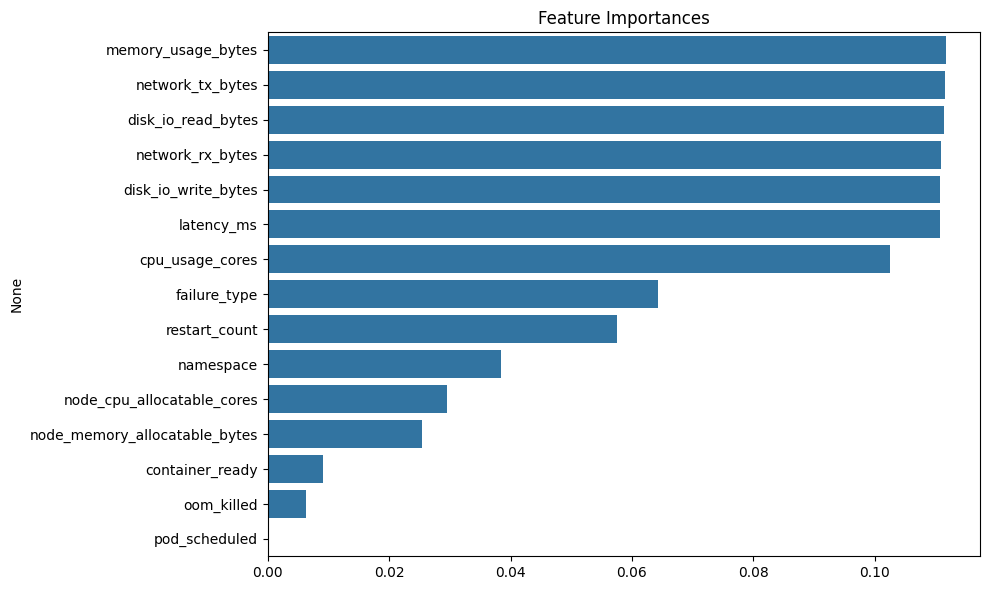

In [14]:
# Install dependencies
!pip install scikit-learn pandas matplotlib seaborn shap --quiet

# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset (upload manually if running in Colab)
from google.colab import files
uploaded = files.upload()

df = pd.read_csv(list(uploaded.keys())[0])

# Convert timestamp
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Drop columns not needed immediately
df = df.drop(columns=['pod_name', 'node_name'])

# Encode categorical variables
label_encoders = {}
for col in ['namespace', 'failure_type']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Feature columns (exclude labels and obvious outcome fields)
features = df.drop(columns=[
    'timestamp', 'failure_injected', 'failure_detected', 'will_fail_soon'
])
target = df['will_fail_soon']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target,
                                                    test_size=0.2,
                                                    shuffle=False)  # time-aware split

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Evaluate
y_pred = model.predict(X_test_scaled)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Feature importances
plt.figure(figsize=(10, 6))
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.title("Feature Importances")
sns.barplot(x=importances[indices], y=X_train.columns[indices])
plt.tight_layout()
plt.show()


In [15]:
from sklearn.utils import class_weight

# Compute class weights
weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)

# Re-train with weights
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train, sample_weight=weights)


RandomForestClassifier(random_state=42)

In [16]:
y_pred = model.predict(X_test_scaled)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

       False       0.63      0.99      0.77      2692
        True       0.48      0.02      0.04      1583

    accuracy                           0.63      4275
   macro avg       0.56      0.50      0.40      4275
weighted avg       0.58      0.63      0.50      4275

Confusion Matrix:
 [[2660   32]
 [1553   30]]


In [17]:
!pip install imbalanced-learn --quiet

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

# Retrain model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_resampled, y_resampled)

# Re-evaluate
y_pred = model.predict(X_test_scaled)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

       False       0.63      0.89      0.74      2692
        True       0.37      0.10      0.16      1583

    accuracy                           0.60      4275
   macro avg       0.50      0.50      0.45      4275
weighted avg       0.53      0.60      0.53      4275

Confusion Matrix:
 [[2408  284]
 [1418  165]]


In [18]:
# Install XGBoost and imbalanced-learn
!pip install xgboost imbalanced-learn --quiet

import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV

# SMOTE resampling
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

# XGBoost classifier
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=1,
    random_state=42
)

# Train model
xgb_model.fit(X_resampled, y_resampled)

# Predictions
y_pred = xgb_model.predict(X_test_scaled)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:45:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.600701754385965
Precision: 0.36283185840707965
Recall: 0.10360075805432722
F1 Score: 0.16117936117936119

Confusion Matrix:
 [[2404  288]
 [1419  164]]


In [19]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42),
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid.fit(X_resampled, y_resampled)

# Best model
best_model = grid.best_estimator_

# Predict again
y_pred = best_model.predict(X_test_scaled)

# Metrics
print("Best Parameters:", grid.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 200, 'subsample': 0.8}
Accuracy: 0.5616374269005848
Precision: 0.3615604186489058
Recall: 0.24005053695514844
F1 Score: 0.2885345482156416
Confusion Matrix:
 [[2021  671]
 [1203  380]]


In [20]:
# Remediation logic based on prediction and failure_type
def remediate(row, prediction):
    if prediction == 1:  # Will fail soon
        fail_type = row['failure_type']
        if fail_type == label_encoders['failure_type'].transform(['pod_stuck'])[0]:
            return "Restart pod"
        elif fail_type == label_encoders['failure_type'].transform(['cpu_throttle'])[0]:
            return "Scale up pod CPU"
        elif fail_type == label_encoders['failure_type'].transform(['memory_leak'])[0]:
            return "Increase memory allocation"
        elif fail_type == label_encoders['failure_type'].transform(['node_reboot'])[0]:
            return "Evacuate pod from node"
        else:
            return "Alert admin"
    else:
        return "No action needed"

# Apply to test data
X_test_copy = X_test.copy()
X_test_copy['prediction'] = y_pred
X_test_copy['remediation_action'] = X_test_copy.apply(lambda row: remediate(row, row['prediction']), axis=1)

# Show sample actions
X_test_copy[['prediction', 'remediation_action']].head(10)


,prediction,remediation_action
17099,1,Alert admin
17100,1,Alert admin
17101,0,No action needed
17102,1,Alert admin
17103,0,No action needed
17104,1,Alert admin
17105,1,Alert admin
17106,0,No action needed
17107,0,No action needed
17108,0,No action needed


In [21]:
df['failure_type'].unique()


array([10, 13,  4,  6,  5,  8,  3, 12, 14,  0,  7,  1,  9, 11,  2])

In [22]:
# This assumes you already have X_test_copy with 'prediction' and 'failure_type' columns

# Count how many times each failure type was predicted as "will fail soon"
predicted_failures = X_test_copy[X_test_copy['prediction'] == 1]
failure_type_counts = predicted_failures['failure_type'].value_counts().sort_values(ascending=False)

# Decode failure_type to original names
decoded_failure_types = failure_type_counts.rename(index=lambda x: label_encoders['failure_type'].inverse_transform([x])[0])

# Display
print("Predicted Failure Types:")
print(decoded_failure_types)


Predicted Failure Types:
failure_type
filesystem_error       92
container_crash        91
dns_failure            82
high_latency           77
cpu_throttle           77
pod_stuck              73
network_loss           66
disk_full              66
pod_eviction           65
kubelet_down           62
image_pull_error       61
resource_starvation    61
node_reboot            60
oom_kill               59
memory_leak            59
Name: count, dtype: int64


In [23]:
# Predict probabilities instead of binary outcomes
y_proba = model.predict_proba(X_test_scaled)[:, 1]  # Probability of failure

# Add to test set
X_test_copy['failure_probability'] = y_proba

# Sort and show most risky pods
high_risk = X_test_copy.sort_values('failure_probability', ascending=False)
high_risk[['failure_probability', 'failure_type', 'prediction']].head(10)


,failure_probability,failure_type,prediction
20020,0.69,8,0
18820,0.67,11,1
19466,0.66,8,0
19770,0.66,5,1
19196,0.66,6,0
19272,0.66,11,0
19613,0.66,0,1
18867,0.65,4,1
18996,0.65,6,0
20562,0.64,1,1


In [24]:
def explain_reason(row):
    reasons = []
    if row['cpu_usage_cores'] > 0.9 * row['node_cpu_allocatable_cores']:
        reasons.append("High CPU usage")
    if row['memory_usage_bytes'] > 0.9 * row['node_memory_allocatable_bytes']:
        reasons.append("Memory nearing exhaustion")
    if row['restart_count'] > 3:
        reasons.append("Unusual number of restarts")
    if not row['container_ready']:
        reasons.append("Container not ready")
    return ", ".join(reasons) if reasons else "No obvious issues"

# Apply explanation
X_test_copy['reason_summary'] = X_test_copy.apply(explain_reason, axis=1)

# Show top failure with explanation
X_test_copy[X_test_copy['prediction'] == 1][['failure_probability', 'reason_summary']].head(5)


,failure_probability,reason_summary
17099,0.39,Unusual number of restarts
17100,0.55,Unusual number of restarts
17102,0.44,Unusual number of restarts
17104,0.42,Unusual number of restarts
17105,0.46,Unusual number of restarts


<Figure size 640x480 with 0 Axes>

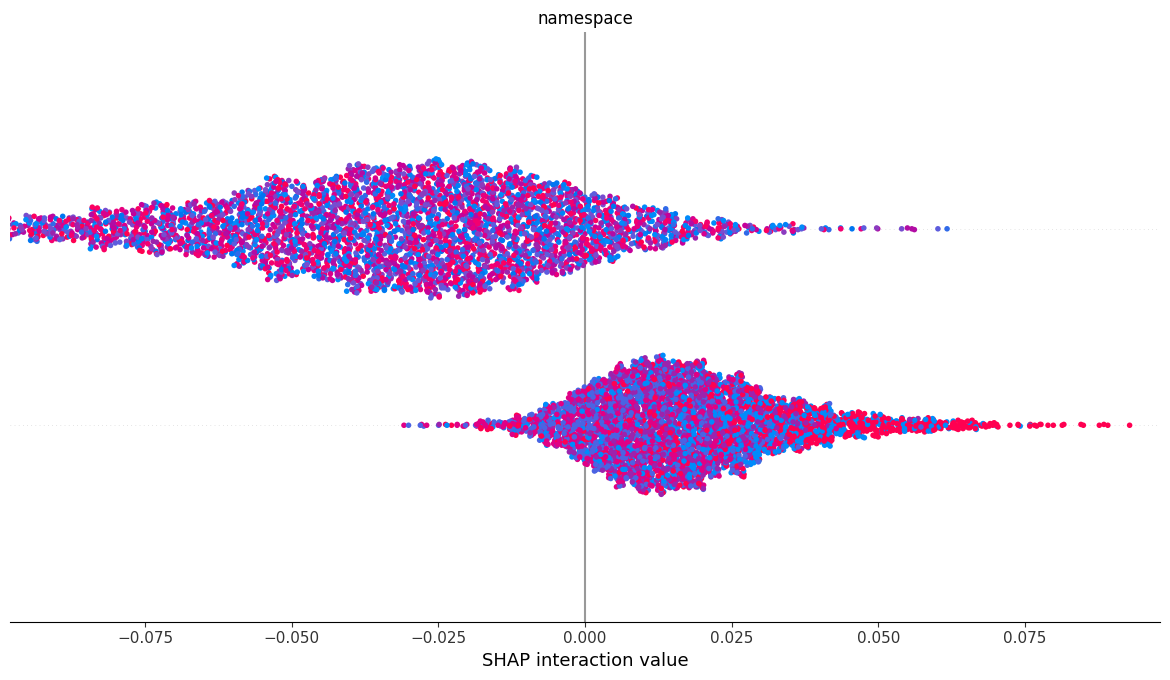

In [25]:
!pip install shap --quiet

import shap
import matplotlib.pyplot as plt

# Explain model predictions using SHAP
explainer = shap.Explainer(model)
shap_values = explainer(X_test_scaled)

# Global summary plot (for failure class)
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)


In [31]:
# Reset index after prediction
X_test_copy = X_test.copy().reset_index(drop=True)
X_test_copy['prediction'] = y_pred


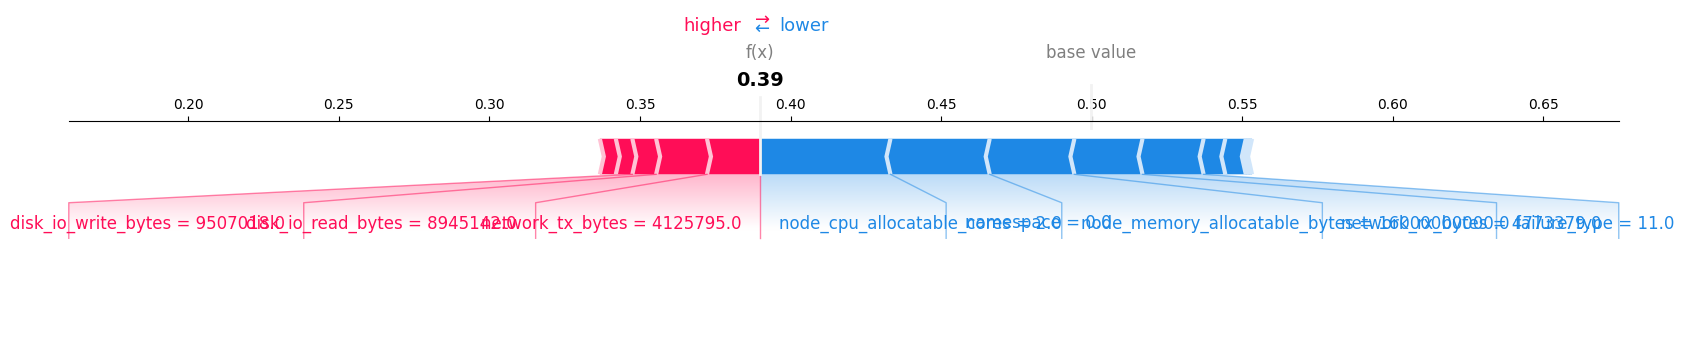

In [32]:
# Get a safe index from the test set (e.g., first predicted failure)
i = X_test_copy[X_test_copy['prediction'] == 1].index[0]

# Plot SHAP explanation for predicted failure
shap.force_plot(
    explainer.expected_value[1],
    shap_values.values[i, :, 1],
    X_test.iloc[i],
    matplotlib=True
)


In [33]:
def generate_reason_from_shap(row, shap_val_row, top_n=3):
    top_features_idx = shap_val_row.argsort()[-top_n:][::-1]
    top_features = X_test.columns[top_features_idx]
    return f"Likely failure due to: {', '.join(top_features)}"

# Generate explanations for first 5 predicted failures
for i in X_test_copy[X_test_copy['prediction'] == 1].index[:5]:
    reason = generate_reason_from_shap(X_test.iloc[i], shap_values.values[i, :, 1])
    print(f"Pod #{i} → {reason}")


Pod #0 → Likely failure due to: network_tx_bytes, disk_io_read_bytes, disk_io_write_bytes
Pod #1 → Likely failure due to: disk_io_write_bytes, disk_io_read_bytes, restart_count
Pod #3 → Likely failure due to: memory_usage_bytes, network_tx_bytes, failure_type
Pod #5 → Likely failure due to: network_tx_bytes, memory_usage_bytes, cpu_usage_cores
Pod #6 → Likely failure due to: disk_io_read_bytes, network_tx_bytes, node_memory_allocatable_bytes


In [34]:
X_test_copy['shap_reason'] = [
    generate_reason_from_shap(X_test.iloc[i], shap_values.values[i, :, 1])
    if y_pred[i] == 1 else "No failure predicted"
    for i in range(len(y_pred))
]


In [36]:
# Predict probabilities of failure
y_proba = model.predict_proba(X_test_scaled)[:, 1]

# Add to test copy
X_test_copy['failure_probability'] = y_proba


In [37]:
# Add back failure_type column if needed
X_test_copy['failure_type'] = X_test['failure_type'].values

# Define remediation logic (redefine if needed)
def remediate(row, prediction):
    if prediction == 1:
        ft = row['failure_type']
        if ft == label_encoders['failure_type'].transform(['pod_stuck'])[0]:
            return "Restart pod"
        elif ft == label_encoders['failure_type'].transform(['cpu_throttle'])[0]:
            return "Scale CPU"
        elif ft == label_encoders['failure_type'].transform(['memory_leak'])[0]:
            return "Increase memory"
        else:
            return "Alert admin"
    else:
        return "No action needed"

# Apply
X_test_copy['remediation_action'] = X_test_copy.apply(lambda row: remediate(row, row['prediction']), axis=1)


In [38]:
X_test_copy[['prediction', 'failure_probability', 'shap_reason', 'remediation_action']].to_csv("final_output.csv", index=False)


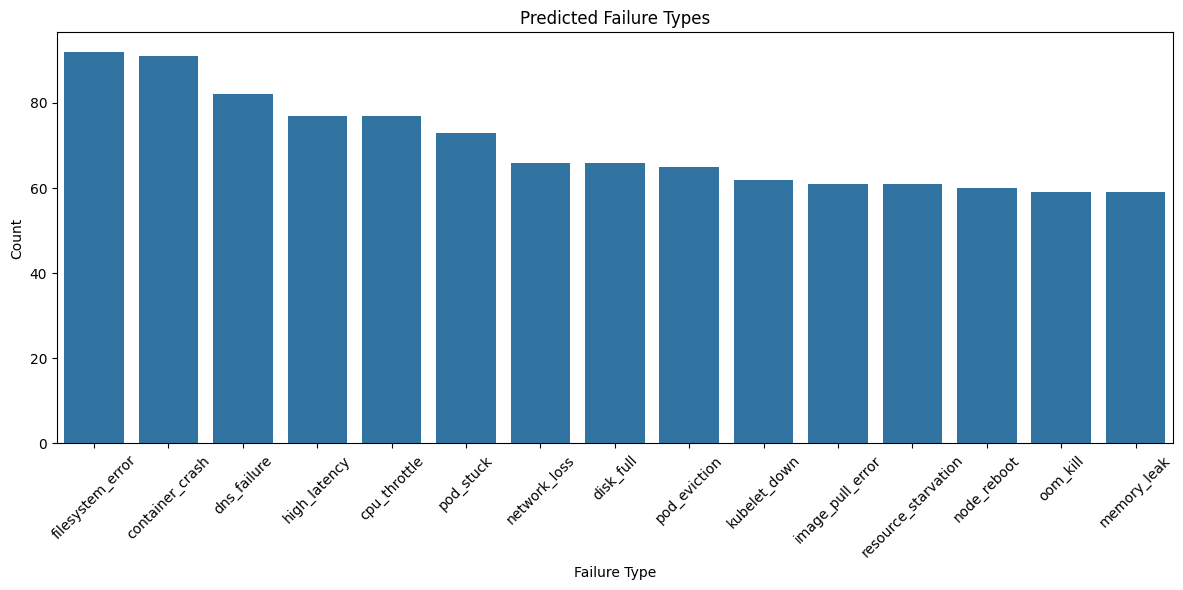

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count failure types where model predicted failure
failures = X_test_copy[X_test_copy['prediction'] == 1]
fail_type_counts = failures['failure_type'].value_counts()
fail_type_labels = label_encoders['failure_type'].inverse_transform(fail_type_counts.index)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=fail_type_labels, y=fail_type_counts.values)
plt.xticks(rotation=45)
plt.title("Predicted Failure Types")
plt.xlabel("Failure Type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


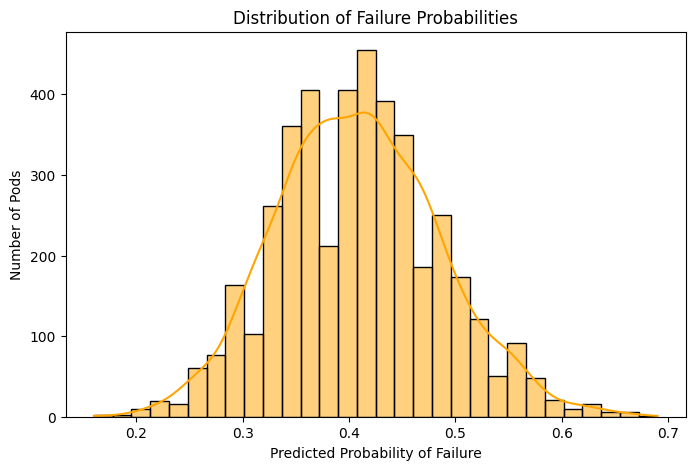

In [40]:
# Histogram of predicted probabilities
plt.figure(figsize=(8, 5))
sns.histplot(X_test_copy['failure_probability'], bins=30, kde=True, color="orange")
plt.title("Distribution of Failure Probabilities")
plt.xlabel("Predicted Probability of Failure")
plt.ylabel("Number of Pods")
plt.show()


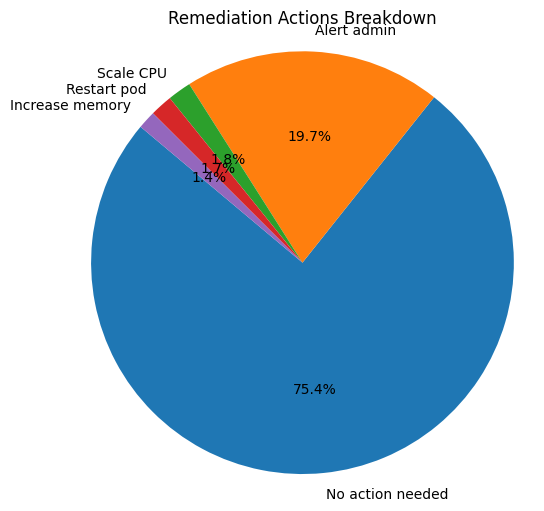

In [41]:
# Pie chart of actions
action_counts = X_test_copy['remediation_action'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(action_counts, labels=action_counts.index, autopct='%1.1f%%', startangle=140)
plt.title("Remediation Actions Breakdown")
plt.axis('equal')
plt.show()


<Figure size 640x480 with 0 Axes>

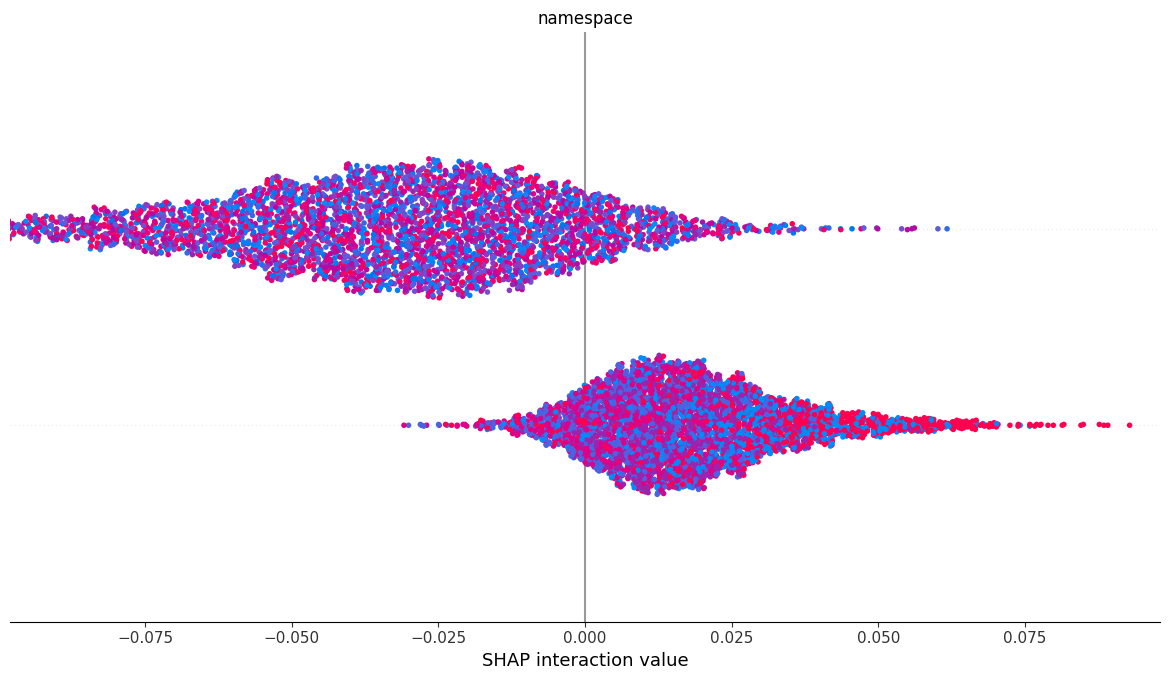

In [42]:
# SHAP bar plot
shap.summary_plot(shap_values, X_test, plot_type="bar")


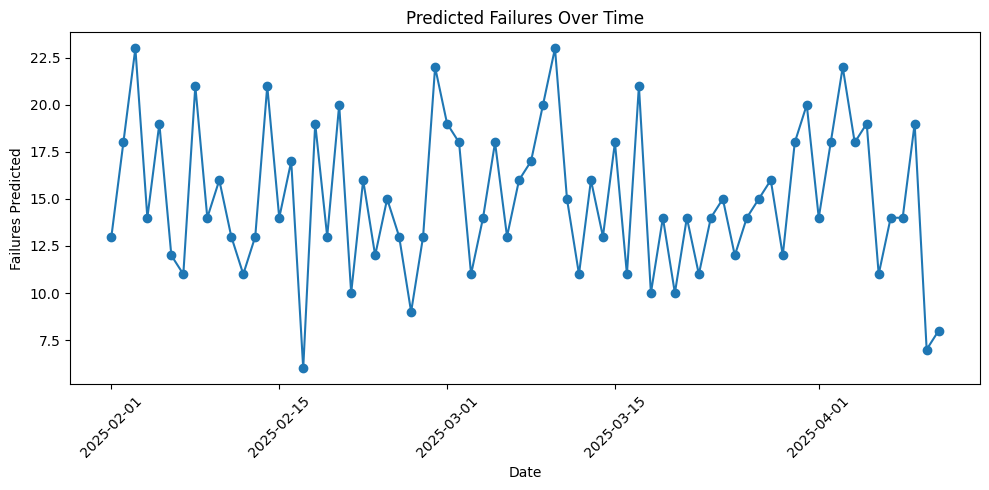

In [43]:
# Add timestamp back for time analysis
X_test_copy['timestamp'] = df['timestamp'].iloc[X_test_copy.index].values

# Count predictions per day
X_test_copy['date'] = pd.to_datetime(X_test_copy['timestamp']).dt.date
failure_trend = X_test_copy[X_test_copy['prediction'] == 1].groupby('date').size()

# Plot
plt.figure(figsize=(10, 5))
failure_trend.plot(kind='line', marker='o')
plt.title("Predicted Failures Over Time")
plt.xlabel("Date")
plt.ylabel("Failures Predicted")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
